In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

In [255]:
#Read the csv file
df = pd.read_csv("yelp_data_official_training.csv", low_memory=False, delimiter='|')
df.head()

,ID,Category,Review Text
0,0,2,Don't waste your time. We had two different p...
1,1,2,I will start by saying we have a nice new deck...
2,2,2,When I wanted a deck for the back of my home I...
3,3,5,Our cat went out the other night and must have...
4,4,5,Greentree Animal clinic is the absolute best! ...


In [256]:
#Take out NaN
filtered_data = df["Review Text"].notnull()
df_filtered = df[filtered_data]

#Shuffle the data
random_index = np.random.permutation(df_filtered.index)
df_shuffled = df.ix[random_index, ['Category', 'Review Text']]
df_shuffled.reset_index(drop=True, inplace=True)
df_shuffled[:5]

,Category,Review Text
0,3,Dr G is AMAZING. He took the time to listen an...
1,2,Pilgrim Cleaners just cleaned my parents' hous...
2,5,The staff at Power Road Animal Hospital is awe...
3,2,Recently looking for single apartments in the ...
4,3,You wont find more competent surgeons and bett...


we shuffle the rows and create train and dev sets 

In [257]:
#Split the data into train and dev
rows, columns = df_shuffled.shape
train_size = round(rows*.7)
dev_size   = round(rows*.3)


df_train = df_shuffled.loc[:train_size]
df_dev = df_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)

## Train the data

Following is the same code from Scikit-Learn notebook

In [258]:
#features
def unigram_feature(x, unigram):
    if(type(x) == float):
        print(x)
    word_list = x.lower().split(" ")
    return word_list.count(unigram)

def bigram_feature(x, bigram):
    bigram_tuple = tuple(bigram.split())
    word_list = x.lower().split(" ")
    bi = nltk.FreqDist(nltk.bigrams(word_list))
    return bi[bigram_tuple]

In [259]:
#Running features on train set
train_doctor_feature = df_train['Review Text'].apply(lambda x: unigram_feature(x, ('dr')))
train_dry_cleaning_feature = df_train['Review Text'].apply(lambda x: bigram_feature(x, ('dry cleaning')))

In [260]:
df_train_features = pd.DataFrame({'doctor': train_doctor_feature,
                                 'dry cleaning': train_dry_cleaning_feature })

In [261]:
dev_doctor_feature = df_dev['Review Text'].apply(lambda x: unigram_feature(x, ('dr')))
dev_dry_cleaning_feature = df_dev['Review Text'].apply(lambda x: bigram_feature(x, ('dry cleaning')))

In [262]:
df_dev_features = pd.DataFrame({'doctor': dev_doctor_feature,
                               'dry cleaning': dev_dry_cleaning_feature})

##Build the model

In [263]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb = MultinomialNB()
nb_model = nb.fit(df_train_features, df_train.Category)
nb_predictions = nb_model.predict(df_dev_features)

accuracy_score(df_dev.Category, nb_predictions)


0.31680555555555556

In [264]:
df_test = pd.read_csv("yelp_data_official_test_nocategories.csv", low_memory=False, delimiter='|')
df_test.head()

,ID,Review Text
0,0,We had the same doctor in Houston for over 12 ...
1,1,My mother passed away recently at the age of 9...
2,2,"Updating! So, the dispute was resolved at this..."
3,3,We just moved here from WA and are looking for...
4,4,They have lost the best of the best. The last ...


In [265]:
from sklearn.feature_extraction.text import CountVectorizer

#building a vector tokenizer
vec = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=5, stop_words='english', max_features=1000)  
tokenizer = vec.build_tokenizer()

arr_train_feature_sparse = vec.fit_transform(df_train['Review Text'])
arr_train_feature = arr_train_feature_sparse.toarray()

arr_dev_feature_sparse = vec.transform(df_dev["Review Text"])
arr_dev_feature = arr_dev_feature_sparse.toarray()


In [266]:
feature_sum = arr_train_feature.sum(axis=0)   #sum the counts of each feature

df_feature_sum = pd.DataFrame({'counts': feature_sum})
df_feature_sum.index = vec.get_feature_names()

//anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


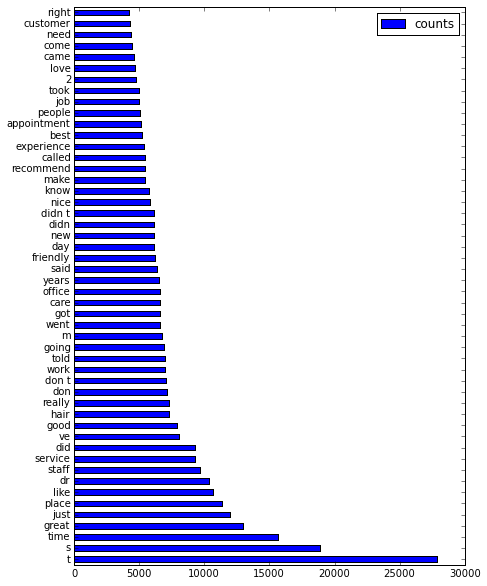

In [267]:
df_feature_sum.sort('counts', ascending=False)[:50].plot(kind='barh', figsize=(7,10));

In [268]:
nb = MultinomialNB()
nb_model = nb.fit(arr_train_feature, df_train.Category)
nb_predictions = nb_model.predict(arr_dev_feature)
accuracy_score(df_dev.Category, nb_predictions)

0.82499999999999996

In [269]:
df_test.head()

,ID,Review Text
0,0,We had the same doctor in Houston for over 12 ...
1,1,My mother passed away recently at the age of 9...
2,2,"Updating! So, the dispute was resolved at this..."
3,3,We just moved here from WA and are looking for...
4,4,They have lost the best of the best. The last ...


In [270]:
arr_test_feature_sparse = vec.transform(df_test['Review Text'])
arr_test_feature = arr_test_feature_sparse.toarray()
nb_test_predictions = nb_model.predict(arr_test_feature)


In [271]:
final_test_predictions = pd.DataFrame( {'Category': nb_test_predictions})

In [272]:
final_test_predictions.to_csv('yelp_data_official_test_submission.csv', header=True, index=True)

In [273]:
final_test_predictions.head()


,Category
0,3
1,3
2,3
3,3
4,1


In [274]:
df_test.head()

,ID,Review Text
0,0,We had the same doctor in Houston for over 12 ...
1,1,My mother passed away recently at the age of 9...
2,2,"Updating! So, the dispute was resolved at this..."
3,3,We just moved here from WA and are looking for...
4,4,They have lost the best of the best. The last ...
